# Part One

Todays problem is quite simple to model, but takes some linear algebra to solve in a reasonable amount of time. 

In [1]:
import re
import numpy as np

def get_points(lines):
    '''Produce arrays of points and velocities from a list of lines'''
    pat = re.compile(r"position=<(-? ?\d*), (-? ?\d*)> velocity=<(-? ?\d*), (-? ?\d*)>")
    points, velocities = [], []
    for l in lines:
        match = [int(n) for n in pat.match(l).groups()]
        points.append(match[:2])
        velocities.append(match[2:])
    points, velocities = np.array(points), np.array(velocities)
    return points, velocities


In [2]:
def read_input(filename):
    with open(filename) as inp:
        return get_points(inp.readlines())

In [3]:
p, v = read_input("input.txt")

My father suggested some things which led me to work out how to find the time at which the points come together. All the points are moving towards their final destinations. Looking only at the y axis, at the point they are in formation all the points on one row will intersect. If we can find two points which will be on the same row, we can calculate the time until they intersect with a little simple linear algebra:

$$t\mathrm{d}y_1 + y_1 = t\mathrm{d}y_2 + y_2$$
$$t = \frac{y_2 - y_1}{\mathrm{d}y_2 - \mathrm{d}y_1}$$

Note, however, that if we choose two points whose velocities are the negative of the each other, then the equation can be simplified to this:

$$t\mathrm{d}y + y_1 = -t\mathrm{d}y + y_2$$
$$t = \frac{y_2 - y_1}{2\mathrm{d}y}$$

Now the problem is simply to find two points which will end up on the same row, or at least very near it (if it's close enough, we can round). To help this, notice that the absolute velocities are all <= 5, as seen below:

In [4]:
print('Maximum and minimum vertical velocities are respectively {} and {}'.format(v.T[1].max(), v.T[1].min()))

Maximum and minimum vertical velocities are respectively 5 and -5


If we take the sets of points with maximum and minimum velocities, therefore, their absolute velocities will be equal. If we assume that some points from the bottom line of the final text will be in both sets, then taking the point with minimum y from both sets will mean taking two points from the same row. We can then use them to calculate the time til they intersect! 

In [5]:
dy = v.T[1].max()
y1 = p[v.T[1] ==  dy].T[1].min()
y2 = p[v.T[1] == -dy].T[1].min()

time_til_intersect = (y2 - y1)/(2*dy)

In [6]:
moved_points = p + time_til_intersect * v

In [7]:
# size of array to make. converting to int allows using for PIL later
size = (int(moved_points.T[1].ptp()) + 1, int(moved_points.T[0].ptp()) + 1)
# coordinates of bottom left corner of final text. used to shift the text to the origin, making it easier to render
shift = moved_points.T.min(1)

In [8]:
im = np.full(size, 255, dtype=np.ubyte)

for point in (moved_points - shift).astype(int):
    im[point[1], point[0]] = 0

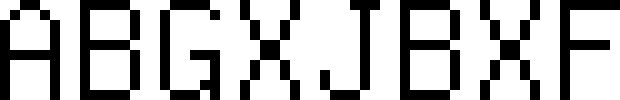

In [9]:
from PIL import Image

render = Image.fromarray(im, 'L')
render.resize([d*10 for d in size[::-1]])

# Part Two

We already calculated this!

In [10]:
print(time_til_intersect)

10619.0


# Animation

I decided to create an animation of the lights coming together. I don't know that much about matplotlib, so thanks to StackOverflow for most of this! I also used [http://www.gizma.com/easing/] this site to understand easing, which was used in the `generate_frames()` function

In [11]:
from matplotlib import pyplot as plt
import matplotlib.animation
from IPython.display import HTML
import math

fig, ax = plt.subplots()
_ = ax.axis('auto')
_ = ax.set_aspect(0.8)
_ = ax.set_axis_off()
l, = ax.plot(*(p*time_til_intersect*(2/3)).T, 'b', linestyle='None', marker='s')
NFRAMES = 100

def animate(i):
    l.set_data(*(p+v*i).T*np.array([[1],[-1]]))
    ax.relim()
    ax.autoscale_view()
    
def generate_frames():
    for t in range(NFRAMES):
        t = t / (NFRAMES - 1) - 1
        yield (time_til_intersect*(1/3)) * (t**5 + 1) + (time_til_intersect*(2/3))


ani = matplotlib.animation.FuncAnimation(fig, animate, frames=generate_frames)

HTML(ani.to_jshtml())